# S&SM
## L3. Alina Kragel, gr. 9

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
from math import gcd
from math import factorial as fac
from scipy.stats import norm, chi2, kstwobign
from scipy.special import erf

In [2]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style='whitegrid', palette='dark:#5A9_r')

##### Все новое - хорошо забытое старое

In [3]:
class LCG:
    def __init__(self, x0, a, c, M):        
        self.a = a
        self.c = c
        self.M = M
        self.x = x0
    
    def __call__(self):
        self.x = (self.x * self.a + self.c) % self.M
        return self.x / self.M
    
    def get_period(self):
        s = list()
        while True:
            x = self()
            if x in s:
                break   
            s.append(x)
        return len(s)

In [4]:
class MMG:
    def __init__(self, g1, g2, k):
        assert k > 0
        self.k = k
        self.g1 = g1
        self.g2 = g2
        self.v = [g1() for _ in range(k)]
    
    def rand(self):
        s = int(self.g2() * self.k)
        rx = self.v[s]
        self.v[s] = self.g1()
        return rx

Более оптимальные параметры для генератора Макларена-Марсальи

In [5]:
MMG = MMG(LCG(2 ** 17, 473109257, 5732841, 2 ** 32), LCG(2 ** 9, 12425, 5813, 2 ** 16), 100)

In [6]:
np.random.seed(42)

Критерий Колмогорова

In [7]:
def ks_test(samples, cdf, alpha=0.05, **kwargs):
    n = len(samples)
    empirical_cdf = np.arange(n) / n
    theoretical_cdf = np.array([cdf(x, **kwargs) for x in sorted(samples)])
    Dn = np.max(np.abs(theoretical_cdf - empirical_cdf))
    ks_value = np.sqrt(n) * Dn

    significance_level = 1 - alpha
    critical_value = kstwobign.ppf(significance_level)

    print(
        f"Критерий Колмогорова",
        "\nH0: различий между тестируемыми выборками нет, как и различий между их распределениями.",
        "\nУровень доверия: ", significance_level
    )
    if ks_value < critical_value:
        print(f"H0 принята: {ks_value} < {critical_value}.")
    else:
        print(f"H0 не принята: {ks_value} >= {critical_value}.")

Генерация выборки на ГММ

In [8]:
def generate_samples(generate_sample, n=1000, **kwargs):
    return np.array([generate_sample(**kwargs) for _ in range(n)])

#### Равномерное распределение на ГММ и встроенном генераторе

In [9]:
def uniform_sample(a=0, b=1):
    x = MMG.rand()
    return (b - a) * x + a

In [10]:
def uniform_cdf(x, a=0, b=1):
    return 0 if x < a else 1 if x > b else (x - a) / (b - a)

In [11]:
a = 10
b = 100

In [12]:
uniform = generate_samples(uniform_sample, a=a, b=b)

In [13]:
print("Теоретическое мат. ожидание:", (a + b) / 2)
print("Несмещенная оценка матожидания:", uniform.mean())
print("Теоретическая дисперсия:", (b - a) ** 2 / 12)
print("Несмещенная оценка дисперсии:", uniform.var())

Теоретическое мат. ожидание: 55.0
Несмещенная оценка матожидания: 54.595004396392035
Теоретическая дисперсия: 675.0
Несмещенная оценка дисперсии: 681.5823473474404


In [14]:
ks_test(uniform, uniform_cdf, a=a, b=b)

Критерий Колмогорова 
H0: различий между тестируемыми выборками нет, как и различий между их распределениями. 
Уровень доверия:  0.95
H0 принята: 0.6098119631852844 < 1.3580986393225505.


<AxesSubplot:ylabel='Count'>

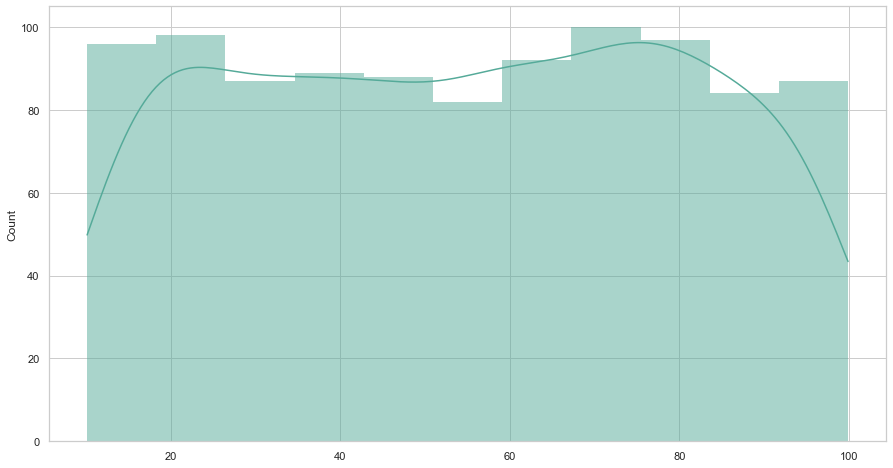

In [15]:
sns.histplot(uniform, kde=True, linewidth=0)

#### Одномерное нормальное распределение на ГММ и встроенном генераторе

In [16]:
def normal_sample(N=12, loc=0, scale=1):
    sum = 0 
    for i in range(0, N):
        sum += np.random.rand()
    return loc + (12 / N) ** 0.5 * (sum - N / 2) * scale

In [17]:
def normal_cdf(x, loc=0, scale=1):
    return 0.5 * (1 + erf((x - loc) / (scale * 2 ** 0.5)))

In [18]:
N = 24
m = 8
s2 = 16
s = s2 ** 0.5

In [19]:
normal = generate_samples(normal_sample, loc=m, scale=s)

In [20]:
print("Теоретическое мат. ожидание:", m)
print("Несмещенная оценка матожидания:", normal.mean())
print("Теоретическая дисперсия:", s2)
print("Несмещенная оценка дисперсии:", normal.var())

Теоретическое мат. ожидание: 8
Несмещенная оценка матожидания: 7.810155456981967
Теоретическая дисперсия: 16
Несмещенная оценка дисперсии: 14.9822605886706


In [21]:
ks_test(normal, normal_cdf, loc=m, scale=s)

Критерий Колмогорова 
H0: различий между тестируемыми выборками нет, как и различий между их распределениями. 
Уровень доверия:  0.95
H0 принята: 1.1696457007832735 < 1.3580986393225505.


<AxesSubplot:ylabel='Count'>

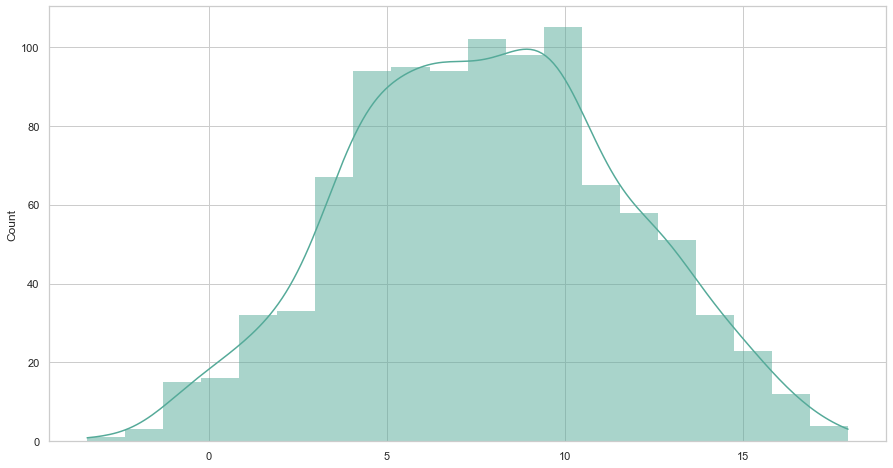

In [22]:
sns.histplot(normal, kde=True, linewidth=0)

#### Логнормальное распределение на ГММ и встроенном генераторе

In [23]:
def lognormal_sample(N=12, loc=0, scale=1):
    sum = 0
    for i in range(0, 12):
        sum += MMG.rand()
    sum -= 6
    return np.exp(loc + scale * sum)

In [24]:
def lognormal_cdf(x, loc=0, scale=1):
    return 0.5 * (1 + erf((np.log(x) - loc) / (scale * 2 ** 0.5)))

In [25]:
N = 20

m = 14
s2 = 9
s = s2 ** 0.5

In [26]:
lognormal = generate_samples(lognormal_sample, loc=m, scale=s)

In [27]:
print("Теоретическое мат. ожидание:", np.exp(m + s2 / 2))
print("Несмещенная оценка матожидания:", lognormal.mean())
print("Теоретическая дисперсия:", (np.exp(s2) - 1) * np.exp(2 * m + s2))
print("Несмещенная оценка дисперсии:", lognormal.var())

Теоретическое мат. ожидание: 108254987.75023076
Несмещенная оценка матожидания: 245080172.8509132
Теоретическая дисперсия: 9.49494750636517e+19
Несмещенная оценка дисперсии: 2.8477508915220705e+19


In [28]:
ks_test(lognormal, lognormal_cdf, loc=m, scale=s)

Критерий Колмогорова 
H0: различий между тестируемыми выборками нет, как и различий между их распределениями. 
Уровень доверия:  0.95
H0 принята: 1.3338877035524728 < 1.3580986393225505.


<AxesSubplot:ylabel='Count'>

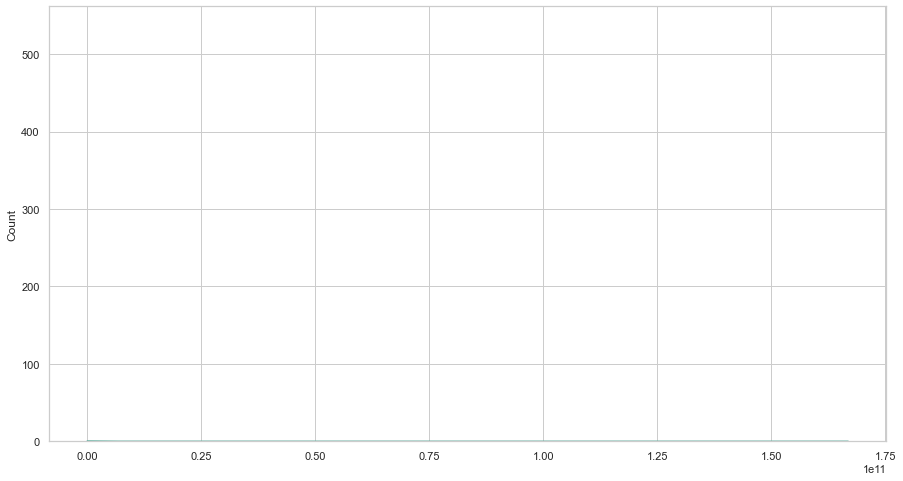

In [29]:
sns.histplot(lognormal, kde=True, linewidth=0)

#### Экспоненциальное распределение на ГММ и встроенном генераторе

In [30]:
def exponential_sample(a=1):
    return -np.log(MMG.rand()) / a

In [31]:
def exponential_cdf(x, a=1):
    return 1 - np.exp(-a * x)

In [32]:
a = 0.5

In [33]:
exponential = generate_samples(exponential_sample, a=a)

In [34]:
print("Теоретическое мат. ожидание:", 1 / a)
print("Несмещенная оценка матожидания:", exponential.mean())
print("Теоретическая дисперсия:", 1 / a ** 2)
print("Несмещенная оценка дисперсии:", exponential.var())

Теоретическое мат. ожидание: 2.0
Несмещенная оценка матожидания: 1.9604950159501853
Теоретическая дисперсия: 4.0
Несмещенная оценка дисперсии: 3.962950328371279


In [35]:
ks_test(exponential, exponential_cdf, a=a)

Критерий Колмогорова 
H0: различий между тестируемыми выборками нет, как и различий между их распределениями. 
Уровень доверия:  0.95
H0 принята: 0.8472389950729274 < 1.3580986393225505.


<AxesSubplot:ylabel='Count'>

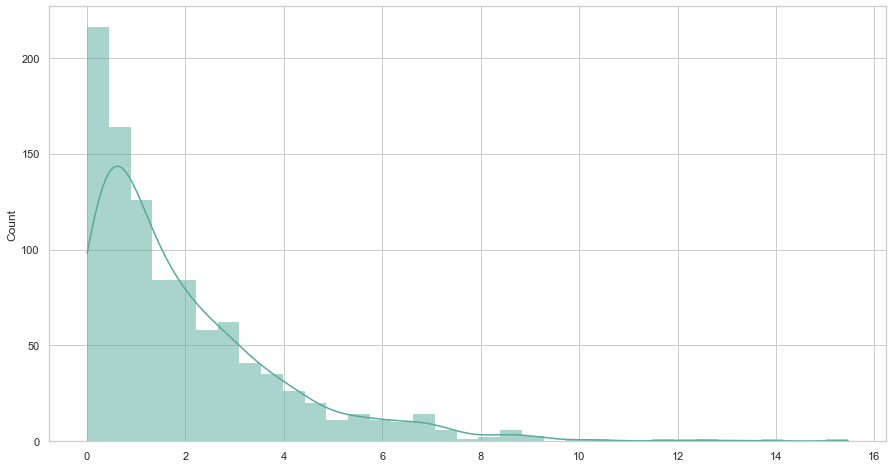

In [36]:
sns.histplot(exponential, kde=True, linewidth=0)

#### Распределение Лапласа на ГММ и встроенном генераторе

In [37]:
def laplace_sample(a):
    n = MMG.rand()
    if n < 0.5:
        return math.log(2 * n) / a
    else:
        return -math.log(2 * (1 - n)) / a

In [38]:
def laplace_cdf(x, a):
    if x < 0:
        return 0.5 * np.exp(a * x);
    else:
        return 1 - 0.5 * np.exp(-a * x);

In [39]:
a = 0.2
mu = 0

In [40]:
laplace = generate_samples(laplace_sample, a=a)

In [41]:
print("Теоретическое мат. ожидание:", mu)
print("Несмещенная оценка матожидания:", laplace.mean())
print("Теоретическая дисперсия:", 2 / a ** 2)
print("Несмещенная оценка дисперсии:", laplace.var())

Теоретическое мат. ожидание: 0
Несмещенная оценка матожидания: -0.1719207511144699
Теоретическая дисперсия: 49.99999999999999
Несмещенная оценка дисперсии: 48.725624822174225


In [42]:
ks_test(laplace, laplace_cdf, a=a)

Критерий Колмогорова 
H0: различий между тестируемыми выборками нет, как и различий между их распределениями. 
Уровень доверия:  0.95
H0 принята: 0.6790089254402735 < 1.3580986393225505.


<AxesSubplot:ylabel='Count'>

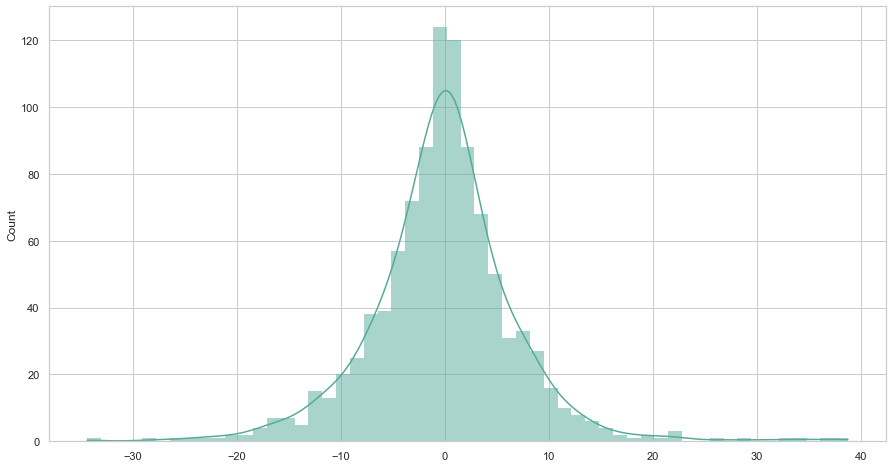

In [43]:
sns.histplot(laplace, kde=True, linewidth=0)

#### Логистическое распределение на ГММ и встроенном генераторе

In [44]:
def logistic_sample(loc=0, scale=1):
    x = MMG.rand()
    return loc + scale * np.log(x / (1 - x))

In [45]:
def logistic_cdf(x, loc=0, scale=1):
    return 1 / (1 + np.exp(-(x - loc) / scale))

In [46]:
mu = 0
k = 1.5

In [47]:
logistic = generate_samples(logistic_sample, loc=mu, scale=k)

In [48]:
print("Теоретическое мат. ожидание:", mu)
print("Несмещенная оценка матожидания:", logistic.mean())
print("Теоретическая дисперсия:", np.pi ** 2 * k ** 2 / 3)
print("Несмещенная оценка дисперсии:", logistic.var())

Теоретическое мат. ожидание: 0
Несмещенная оценка матожидания: 0.0015370439730836125
Теоретическая дисперсия: 7.4022033008170185
Несмещенная оценка дисперсии: 7.826914837644057


In [49]:
ks_test(logistic, logistic_cdf, loc=mu, scale=k)

Критерий Колмогорова 
H0: различий между тестируемыми выборками нет, как и различий между их распределениями. 
Уровень доверия:  0.95
H0 принята: 0.4842028723438637 < 1.3580986393225505.


<AxesSubplot:ylabel='Count'>

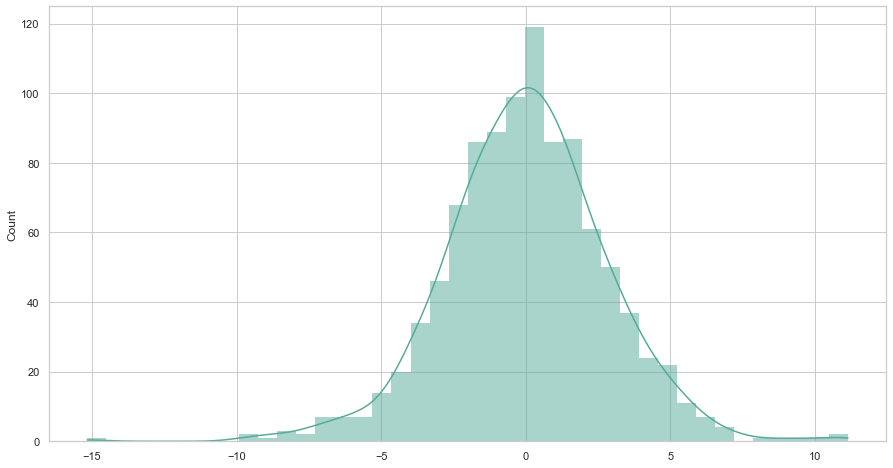

In [50]:
sns.histplot(logistic, kde=True, linewidth=0)